In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly import subplots
import scipy.ndimage as ndi
from skimage import exposure, measure, morphology, segmentation
from segmentflow import segment, view
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# File paths
ct_dir_path = Path(r'../data/F50_1_scan1/')
save_images = False

Loading images...
--> Images loaded as 3D array:  (300, 650, 650)
Plotting images: [0, 100, 200, 299]


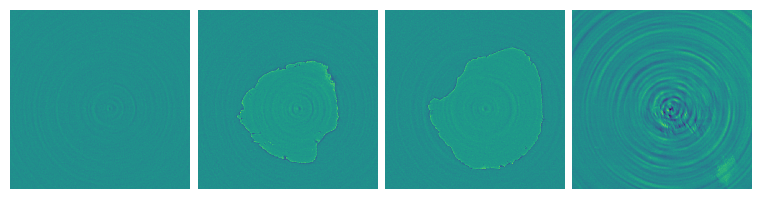

In [6]:
#-------------#
# Load images #
#-------------#
imgs = segment.load_images(
    ct_dir_path,
    slice_crop=[300, 600],
    row_crop=[600, 1250],
    col_crop=[600, 1250],
    convert_to_float=True,
    file_suffix='.tif'
)
# row & col crop deterined in NB 14
slices = [0, 100, 200, 299]
fig, axes = view.plot_slices(
    imgs,
    slices=slices,
    fig_w=7.5,
    dpi=100
)

In [7]:
#---------------#
# Median filter #
#---------------#
imgs_med = segment.preprocess(
    imgs, median_filter=True,
    rescale_intensity_range=None
)

Preprocessing images...
--> Applying median filter...
--> Preprocessing complete


Binarizing images...
--> Calculating Otsu threshold(s)...
--> Binarization complete.
Plotting images: [0, 100, 200, 299]


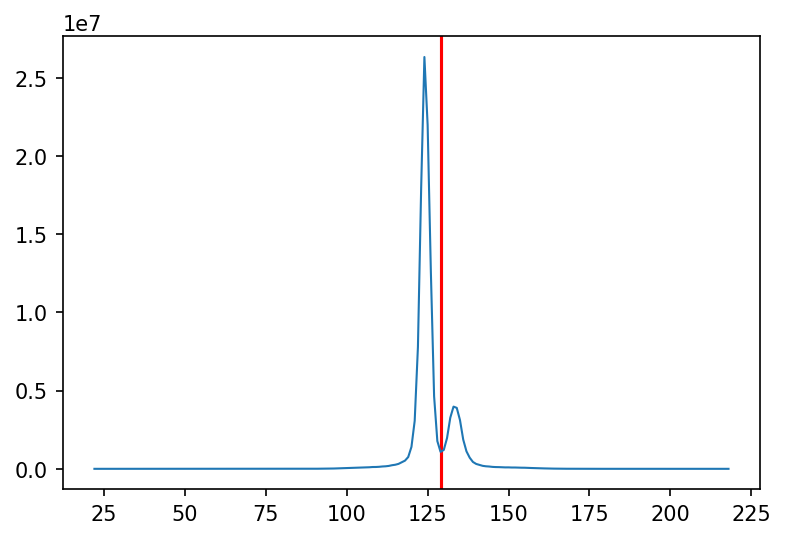

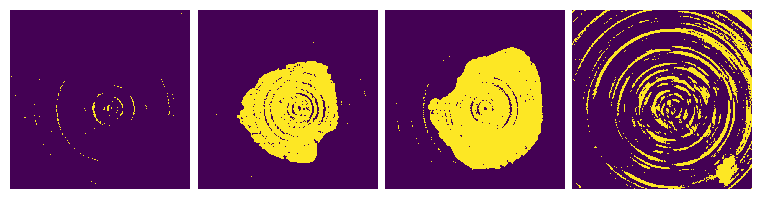

In [8]:
imgs_binarized, thresh_vals = segment.binarize_multiotsu(
    imgs_med, n_otsu_classes=2
)
# Plot histogram
hist, hist_centers = exposure.histogram(imgs_med)
fig, ax = plt.subplots(dpi=150)
ax.plot(hist_centers, hist, lw=1)
for val in thresh_vals:
    ax.axvline(val, c='red', zorder=0)
fig, axes = view.plot_slices(
    imgs_binarized,
    slices=slices,
    fig_w=7.5,
    dpi=100
)

## Crop grain between artifact-heavy slices and remove noise

In [18]:
# zyx
print(f'{imgs_binarized.shape=}')
# yxz
imgs_binarized_zx = np.rot90(imgs_binarized, axes=(2, 0))
print(f'{imgs_binarized_zx.shape=}')

imgs_binarized.shape=(300, 650, 650)
imgs_binarized_zx.shape=(650, 650, 300)


In [32]:
fig = px.imshow(
    imgs_binarized_zx, binary_string=True, animation_frame=0
)
fig.show()

Plotting images: [  0  32  65  98 130 163 196 229]


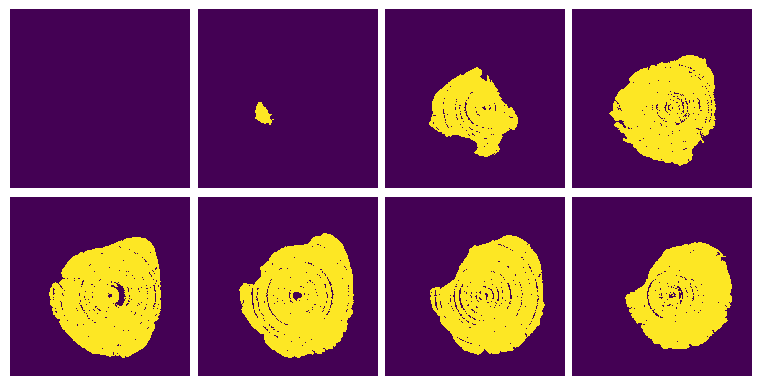

In [44]:
imgs_cropped = imgs_binarized[15:245, ...]
imgs_cleaned = np.zeros_like(imgs_cropped)
for n in range(imgs_cropped.shape[0]):
    imgs_cleaned[n, ...] = morphology.remove_small_objects(
        measure.label(imgs_cropped[n, ...]), min_size=500).astype(bool)
fig, axes = view.plot_slices(
    imgs_cleaned,
    slices=np.linspace(0, len(imgs_cropped) - 1, 8).astype(int),
    imgs_per_row=4,
    fig_w=7.5,
    dpi=100
)

Plotting images: [  0  32  65  98 130 163 196 229]


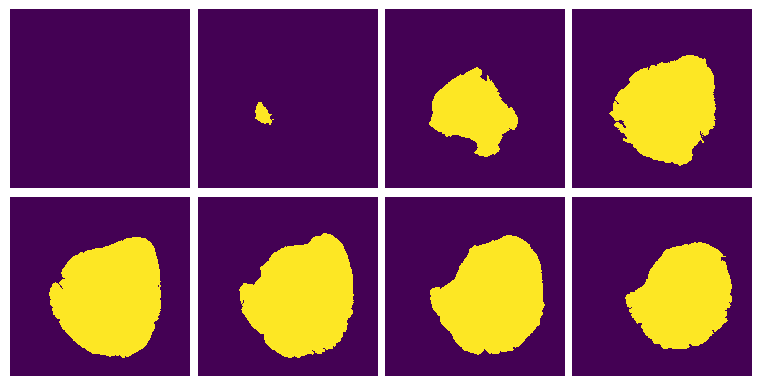

In [45]:
imgs_filled = np.zeros_like(imgs_cleaned)
for n in range(imgs_cleaned.shape[0]):
    imgs_filled[n, ...] = ndi.binary_fill_holes(imgs_cleaned[n, ...])
fig, axes = view.plot_slices(
    imgs_filled,
    slices=np.linspace(0, len(imgs_cropped) - 1, 8).astype(int),
    imgs_per_row=4,
    fig_w=7.5,
    dpi=100
)

In [48]:
fig = px.imshow(
    imgs_filled,
    binary_string=True, animation_frame=0
)
fig.show()

In [49]:
fig = px.imshow(
    np.rot90(imgs_filled, axes=(2, 0)),
    binary_string=True, animation_frame=0
)
fig.show()

## Attempt to generate marker slices for random walker

Plotting images: [  0  42  85 128 170 213 256 299]


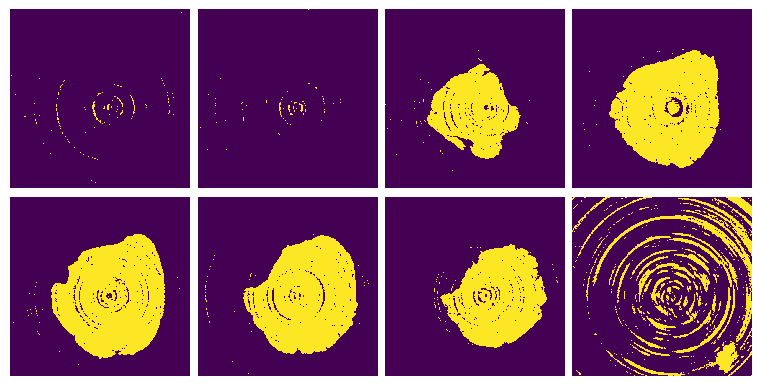

In [6]:
fig, axes = view.plot_slices(
    imgs_binarized,
    slices=np.linspace(0, 299, 8).astype(int),
    imgs_per_row=4,
    fig_w=7.5,
    dpi=100
)

Plotting images: [  0  42  85 128 170 213 256 299]


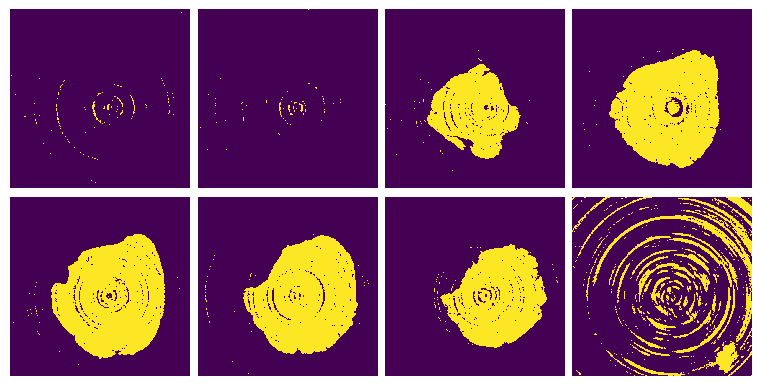

In [7]:
imgs_bw_filt = morphology.remove_small_objects(
    imgs_binarized, min_size=10000)
fig, axes = view.plot_slices(
    # imgs_binarized[0, ...],
    imgs_bw_filt,
    slices=np.linspace(0, 299, 8).astype(int),
    imgs_per_row=4,
    fig_w=7.5,
    dpi=100
)

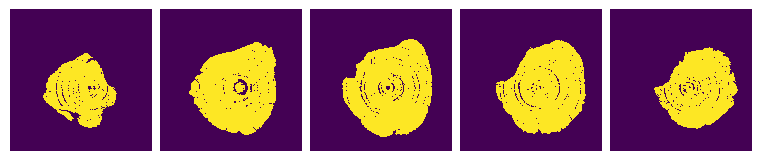

In [8]:
nums = [85, 128, 170, 213, 256]
marker_dict = {}
for n in nums:
    marker_dict[n] = morphology.remove_small_objects(
        measure.label(imgs_binarized[n, ...]), min_size=100).astype(bool)
imgs_markers = list(marker_dict.values())
fig, axes = view.plot_images(
    imgs_markers,
    fig_w=7.5,
    dpi=100
)

Plotting images: [60, 85, 110, 128, 150, 170, 190, 213, 220, 256, 280]


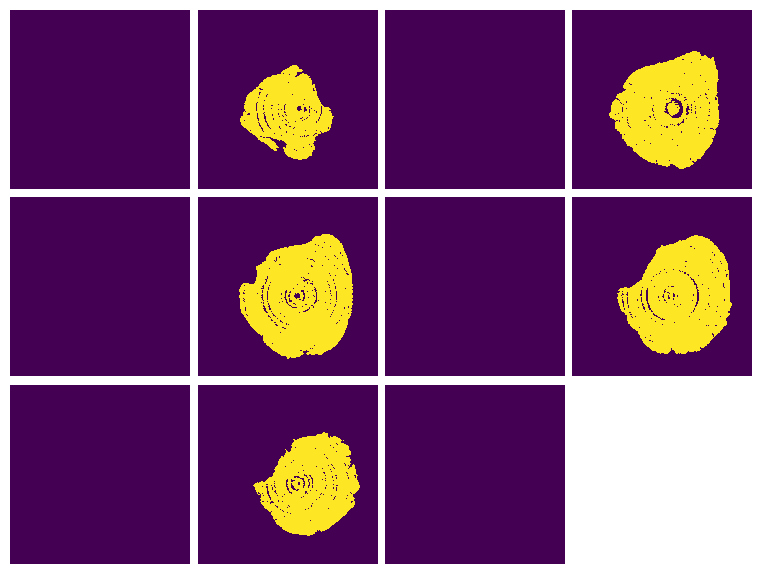

In [9]:
nums = [60, 85, 110, 128, 150, 170, 190, 213, 220, 256, 280]
markers = np.zeros_like(imgs_binarized)
for n, marker_slice in marker_dict.items():
    markers[n] = marker_slice
fig, axes = view.plot_slices(
    markers,
    slices=nums,
    imgs_per_row=4,
    fig_w=7.5,
    dpi=100
)

In [10]:
imgs_binarized = segmentation.random_walker(
    imgs_med, markers, beta=10, mode='cg_j')
nums = [60, 85, 110, 128, 150, 170, 190, 213, 220, 256, 280]
fig, axes = view.plot_slices(
    imgs_binarized,
    slices=nums,
    imgs_per_row=4,
    fig_w=7.5,
    dpi=100
)

## Segmentflow workflow

In [ ]:
#----------------------#
# Read YAML input file #
#----------------------#
yaml_path = Path('')
ui = segment.load_inputs(yaml_file)

#-------------#
# Load images #
#-------------#
print()
imgs = segment.load_images(
    ui['ct_img_dir'],
    slice_crop=ui['slice_crop'],
    row_crop=ui['row_crop'],
    col_crop=ui['col_crop'],
    convert_to_float=True,
    file_suffix=ui['file_suffix']
)

#-------------------#
# Preprocess images #
#-------------------#
print()
imgs_pre = segment.preprocess(
    imgs, median_filter=ui['pre_seg_med_filter'],
    rescale_intensity_range=ui['rescale_range']
)

#-----------------#
# Binarize images #
#-----------------#
print()
imgs_binarized, thresh_vals = segment.binarize_multiotsu(
    imgs_pre, n_otsu_classes=ui['n_otsu_classes'],
    n_selected_thresholds=ui['n_selected_classes'],
)
if ui['save_classes']:
    segment.save_isolated_classes(
        imgs_pre, thresh_vals, ui['stl_dir_location']
    )

#----------------#
# Segment images #
#----------------#
if ui['perform_seg']:
    print()
    segment_dict = segment.watershed_segment(
        imgs_binarized, min_peak_distance=ui['min_peak_dist'],
        use_int_dist_map=ui['use_int_dist_map'],
        exclude_borders=ui['exclude_borders'], return_dict=True
    )
